Train Accuracy: 0.880
Test Accuracy:  0.730

Classification Report (Test):
              precision    recall  f1-score   support

   Non-Toxic       0.73      0.80      0.76       108
       Toxic       0.73      0.65      0.69        92

    accuracy                           0.73       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.73      0.73      0.73       200



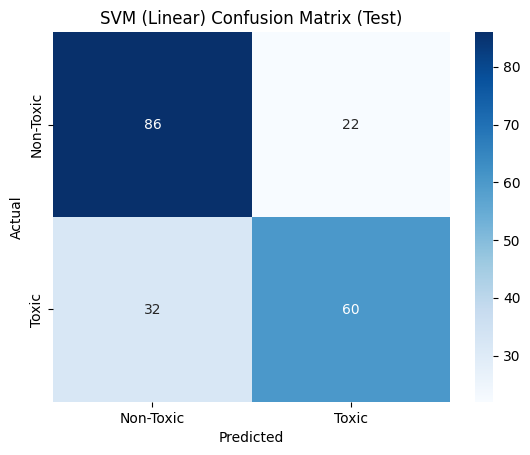

CV Accuracy: 0.686 ± 0.046
CV F1-macro: 0.682 ± 0.045
Top words for TOXIC:
 ['run' 'fuck' 'shit' 'fucking' 'idiot' 'shoot' 'stupid' 'ass' 'bitch'
 'thug']
Top words for NON-TOXIC:
 ['video' 'thank' 'peggy' 'stefan' 'truth' 'good' 'pretty' 'woman' 'great'
 'say']


In [2]:
import pandas as pd
import re

df = pd.read_csv('../data/youtoxic_english_1000.csv')
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+", "", t)
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()
df['CleanText'] = df['Text'].apply(clean_text)
X = df['CleanText']
y = df['IsToxic'].astype(int)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    max_features=1500
)
X_tfidf = vectorizer.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.svm import LinearSVC

svm = LinearSVC(class_weight='balanced', random_state=42,C=0.005, max_iter=5000)
svm.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_pred_test):.3f}\n")

print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=['Non-Toxic', 'Toxic']))

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title('SVM (Linear) Confusion Matrix (Test)')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

from sklearn.model_selection import cross_val_score

acc_scores = cross_val_score(
    svm, X_tfidf, y, cv=5, scoring='accuracy')
f1_scores = cross_val_score(
    svm, X_tfidf, y, cv=5, scoring='f1_macro')

print(f"CV Accuracy: {acc_scores.mean():.3f} ± {acc_scores.std():.3f}")
print(f"CV F1-macro: {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")

import numpy as np

feature_names = vectorizer.get_feature_names_out()
coefs = svm.coef_[0]
top_pos = np.argsort(coefs)[-10:]
top_neg = np.argsort(coefs)[:10]
print("Top words for TOXIC:\n", feature_names[top_pos][::-1])
print("Top words for NON-TOXIC:\n", feature_names[top_neg])

